
## Music Classification Mini-Project

## Author: Collin Guidry

## Step 2: Model Training

### Purpose:
This notebook is designed to train a model to perform a classification task on a collection of 30-second-long Midi files.

### Goal:
Given a collection of compositions written by four composers, train a model to classify whether a composition was NOT written by one of the four composers.

### Challenges & Discussion 
The most significant challenge of this problem is that the class to be predicted (compositions not by the four composers) is not provided in the training data. This underscores the importance of model robustness and the ability to make predictions on out-of-sample observations. Access to additional training data would simplify the problem, allowing a model to learn which musical components are unlike those of the four composers.

Several ML approaches were considered, each with its own set of pros and cons:

| Chosen | Approach                                         | Classes       | Final Prediction Based on                                               | Pros                                   | Cons                                                                                          |
|--------|--------------------------------------------------|---------------|--------------------------------------------------------------------------|---------------------------------------|-----------------------------------------------------------------------------------------------|
| Y      | Multi-class classification of composer names      | 0, 1, 2, 3    | Maximum threshold of predicted class probabilities. "Not from one of the four composers" if the maximum predicted probability is below the threshold | Consolidated model training process.  | Post-processing of predictions / thresholding separate from model training. Choice of threshold can significantly affect performance. |
| N      | Binary classification of each composer name       | 0,1; 0,1; 0,1; 0,1 | Comparison of independent model results. "Not from one of the four composers" if all models predict a low probability. | More interpretable results.           | Accumulation of errors when combining predictions / Bernoulli trial type effects. Class probabilities of each composer must not sum to 1. Less explainable approach. |
| N      | Unsupervised learning / Outlier detection                                | None          | Samples with outlier scores above a certain threshold are classified as "not from one of the four composers" | Does not require training on specific classes. Can detect anomalies that do not fit any known class. | Threshold selection may be difficult. Requires a well-defined notion of what constitutes an outlier and which features have out-of-sample variance. | 


The chosen approach is simple and feasible given the time constraints of this problem. It involves training a single multi-class classification model for the four composers, using proper feature engineering, feature selection, and validation methods to make accurate out-of-sample predictions.

Another method to consider for this problem is to use deep learning models that make use of chroma features from the Midi piano roll. These features are multidimensional and not well-suited for classical ML approaches, but can be used to identify patterns in the composition, similar to patterns in an image. In future implementations, convolutional neural networks could be used to classify composers based on these patterns.

### General Steps for Approach

1) Feature Engineering
    - Creation of "flat" single-dimensional features for each Midi file
    - Creation of chroma features (not used in current approach)
    - Feature processing applied to both train and inference datasets
2) EDA 
    - "Which features show variance among the four composers?"
    - Predictive power scores 
        - Pre-model feature importances
    - Initial feature selection
3) Train/Test Split
    - Split strategy: Grouped
        - Chunks of the same composition will not be split across train/test
        -   This assumption is the same for the holdout dataset
        - Improves robustness
    - Training Data: Stratified Sampling
        - Extreme class imbalance observed
        - Normalize the training data to equal proportions of each class
        - No sampling of test data, to represent true accuracy
4) Model Selection, Cross Validation, and Tuning (Combined Process)
    - Final feature selection
    - A list of models are fit and tested, each with a hyperparameter grid
    - "Grouped" cross validation strategy used for tuning prevents data leakage

5) Model Validation
    - Retrieve best-fit model, re-fit on all training data with best parameters
    - Validate accuracy on test (holdout) set
    - Calculate performance metrics
        - Confusion matrix
        - Precision, recall, f1-score by composer

6) Perform Inference
    - Use best-fit model to predict the composer of the un-labeled inference dataset
        - Calculate the largest predicted probability (of a single composer) for each composition
        - Set confidence threshold of 0.65
        - If the largest composer probability is below the the confidence threshold, predict 0 (not by the four composers) for the chunk
    - Predict at the song-level
        - As it is unlear how the client prefers to reconcile 30-second interval predictions to the composition-level, final predictions are based on the first 30 seconds of each composition


### Conclusion

In this challenge, a random forest multi-class classification approach was used to solve the problem of identifying compositions not written by the four composers. The model achieved an accuracy of 85% on the holdout test data, indicating its ability to generalize to compositions which it was not trained on.

The analysis also identified potential areas for improvement, such as mining features from the piano roll, implementing PCA to transform correlated features, and creating embeddings for the instrument one-hot-encoded features. These additional features and EDA could potentially lead to a more accurate model.

It is important to note that the threshold of 0.65 used to determine if a composition is not written by one of the four composers is somewhat arbitrary, and further experimentation with different thresholds may be required to optimize the model's performance.

In conclusion, the random forest classifier presented in this study is a promising solution with the potential to become more accurate with further refinement and feature engineering.

# Import Libraries

In [1]:
import mido
import pretty_midi
import os
import numpy as np
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps

pd.set_option('max_columns', 100)

# Load Data

In [2]:
df = pd.read_pickle('../data/processed/train_processed.pkl')

In [3]:
df_final_test = pd.read_pickle('../data/processed/test_processed.pkl')

# 1) Feature Eng.

In [4]:

def dominant_pitch_prevalence(pm):
    """Calculates the fraction of note-ons corresponding to the most common pitch."""
    # Get a list of all pitches in the pretty_midi object
    pitches = [n.pitch for n in pm.instruments for n in n.notes]
    # Get the most common pitch
    most_common_pitch = max(set(pitches), key=pitches.count)
    # Get the number of note-ons corresponding to the most common pitch
    num_most_common_pitch = sum(1 for n in pm.instruments for n in n.notes if n.pitch == most_common_pitch)
    # Get the total number of note-ons
    total_notes = sum(len(n.notes) for n in pm.instruments)
    # Calculate the fraction of note-ons corresponding to the most common pitch
    return num_most_common_pitch / total_notes

def dominant_pitch_class_prevalence(pm):
    """Calculates the fraction of note-ons corresponding to the most common pitch class."""
    # Get a list of all pitch classes in the pretty_midi object
    pitch_classes = [n.pitch % 12 for n in pm.instruments for n in n.notes]
    # Get the most common pitch class
    most_common_pitch_class = max(set(pitch_classes), key=pitch_classes.count)
    # Get the number of note-ons corresponding to the most common pitch class
    num_most_common_pitch_class = sum(1 for n in pm.instruments for n in n.notes if n.pitch % 12 == most_common_pitch_class)
    # Get the total number of note-ons
    total_notes = sum(len(n.notes) for n in pm.instruments)
    # Calculate the fraction of note-ons corresponding to the most common pitch class
    return num_most_common_pitch_class / total_notes

def dominant_interval(pm):
    """Calculates the number of semi-tones between the two most common pitch classes."""
    # Get a list of all pitch classes in the pretty_midi object
    pitch_classes = [n.pitch % 12 for n in pm.instruments for n in n.notes]
    # Get the two most common pitch classes
    most_common_pitch_classes = sorted(set(pitch_classes), key=pitch_classes.count, reverse=True)[:2]
    # Calculate the number of semi-tones between the two most common pitch classes
    return abs(most_common_pitch_classes[0] - most_common_pitch_classes[1])

def pitch_class_variety_common(pm):
    """Calculates the number of pitch classes that represent at least 9% of the notes."""
    # Get a list of all pitch classes in the pretty_midi object
    pitch_classes = [n.pitch % 12 for n in pm.instruments for n in n.notes]
    # Create a set of pitch classes that appear in at least 9% of the notes
    common_pitch_classes = set(pc for pc in set(pitch_classes) if pitch_classes.count(pc) / len(pitch_classes) >= 0.09)
    # Count the number of common pitch classes
    variety = len(common_pitch_classes)
    return variety

def pitch_class_variety_rare(pm):
    """Calculates the number of pitch classes played at least once."""
    # Get a list of all pitch classes in the pretty_midi object
    pitch_classes = [n.pitch % 12 for n in pm.instruments for n in n.notes]
    # Create a set of pitch classes that appear at least once
    rare_pitch_classes = set(pitch_classes)
    # Count the number of rare pitch classes
    variety = len(rare_pitch_classes)
    return variety

def register_variety(pm):
    """Calculates the number of pitches played at least once."""
    # Get a list of all pitches in the pretty_midi object
    pitches = [n.pitch for n in pm.instruments for n in n.notes]
    # Create a set of pitches that appear at least once
    rare_pitches = set(pitches)
    # Count the number of rare pitches
    variety = len(rare_pitches)
    return variety

def pitch_range(pm):
    """Calculates the difference between the highest and lowest pitches."""
    # Get a list of all pitches in the pretty_midi object
    pitches = [n.pitch for n in pm.instruments for n in n.notes]
    # Calculate the range of pitches
    pitch_range = max(pitches) - min(pitches)
    return pitch_range




In [5]:
def add_midi_basic_features(df:pd.DataFrame):

    df['num_instruments'] = df['midi'].apply(lambda midi: len(midi.instruments) )

    df['instruments_list'] = df['midi'].apply(lambda midi: [i.name for i in midi.instruments] )
    df['instruments_programs_list'] = df['midi'].apply(lambda midi: [i.program for i in midi.instruments] )
    df['num_programs'] = df['instruments_programs_list'].apply(len)

    df['tempo'] = df['midi'].apply(lambda midi: midi.get_tempo_changes()[1][0] )

    df['resolution'] = df['midi'].apply(lambda midi: midi.resolution )

    df['time_signature_ratio'] = df['midi'].apply(lambda midi: midi.time_signature_changes[0].numerator / midi.time_signature_changes[0].denominator)
    
    def key_sig(midi):
        try: return midi.key_signature_changes[0].key_number 
        except: return pd.NA
    df['key_number'] = df['midi'].apply(lambda midi: key_sig(midi)  )


    # instument_lists = df['instruments_programs_list']
    # unique_values = set().union(*instument_lists)
    # unique_values

    one_hot_list = ['cello','bassoon','piano','flute','viola','violin','clarinet']
    s = df['instruments_list'].apply(lambda lst: ' '.join(lst).lower() )
    df_ohe = pd.DataFrame([[1 if value in lst else 0 for value in one_hot_list] for lst in s], columns=one_hot_list)
    df = pd.concat([df,df_ohe], axis=1)

    one_hot_list2 = [0, 6, 40, 41, 42, 43, 45, 60, 68, 70, 71, 73]
    one_hot_list2_colnames = [f'program_{i}' for i in one_hot_list2]

    s = df['instruments_programs_list']
    df_ohe = pd.DataFrame([[1 if value in lst else 0 for value in one_hot_list2] for lst in s], columns=one_hot_list2_colnames)
    df = pd.concat([df,df_ohe], axis=1)


    pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    pitch_classes_colnames = [f'freq_{i}' for i in pitch_classes]
    df[pitch_classes_colnames] = df['midi'].apply(lambda midi: midi.get_pitch_class_histogram()).apply(pd.Series)


    df['dominant_pitch_prevalence'] = df['midi'].apply( dominant_pitch_prevalence  )
    df['dominant_pitch_class_prevalence'] = df['midi'].apply( dominant_pitch_class_prevalence  )
    df['dominant_interval'] = df['midi'].apply( dominant_interval  )
    df['pitch_class_variety_common'] = df['midi'].apply( pitch_class_variety_common  )
    df['pitch_class_variety_rare'] = df['midi'].apply( pitch_class_variety_rare  )
    df['register_variety'] = df['midi'].apply( register_variety  )
    df['range'] = df['midi'].apply( pitch_range  )

    return df


df = add_midi_basic_features(df)
df_final_test = add_midi_basic_features(df_final_test)

In [6]:
def add_midi_chroma_features(df:pd.DataFrame):
    # Chroma features (from piano roll)

    def piano_roll_chroma_features(midi):
        piano_roll = midi.get_piano_roll()
        # Extract the chroma features from the piano roll
        chroma_features = np.zeros((12, piano_roll.shape[1]))
        # for i in range(12):
        #     chroma_features[i, :] = np.max(piano_roll[i::12, :], axis=0)
        #     chroma_features[i, :] /= np.linalg.norm(chroma_features[i, :])

        return chroma_features
    
    df['chroma_matrix'] = df['midi'].apply( piano_roll_chroma_features )


    df['chroma_mean'] = df['chroma_matrix'].apply(lambda chroma: np.mean(chroma, axis=1) )
    df['chroma_std'] = df['chroma_matrix'].apply(lambda chroma: np.std(chroma, axis=1) )
    df['chroma_peak_to_average_ratio'] = df['chroma_matrix'].apply(lambda chroma: np.max(chroma, axis=1) / (np.mean(chroma, axis=1) + 1e-6) )

    def chroma_entropy(chroma):
        eps = 1e-6  # small value to avoid log(0)
        prob = chroma / (np.sum(chroma, axis=0, keepdims=True) + eps)  # compute probability distribution
        entropy = -np.sum(prob * np.log2(prob + eps), axis=1)  # compute entropy
        return entropy

    df['chroma_entropy'] = df['chroma_matrix'].apply( chroma_entropy )

    return df

df = add_midi_chroma_features(df)
df_final_test = add_midi_chroma_features(df_final_test)



In [7]:

pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
pitch_classes_colnames = [f'freq_{i}' for i in pitch_classes]

df['target'] = df['composer'].apply(lambda x: 0 if x=='' else 1 if x=='Beethoven' else 2 if x=='Brahms' else 3 if x=='Schubert' else 4)
df['target'].value_counts()
composers = ['Bach','Beethoven','Brahms','Schubert']

In [8]:
midi = df.iloc[0]['midi']
midi

In [9]:
df.head()

,track_path,composer,track_name,id,catalog_name,path_other,chunk_size_seconds,iter,midi,split,num_instruments,instruments_list,instruments_programs_list,num_programs,tempo,resolution,time_signature_ratio,key_number,cello,bassoon,piano,flute,viola,violin,clarinet,program_0,program_6,program_40,program_41,program_42,program_43,program_45,program_60,program_68,program_70,program_71,program_73,freq_C,freq_C#,freq_D,freq_D#,freq_E,freq_F,freq_F#,freq_G,freq_G#,freq_A,freq_A#,freq_B,dominant_pitch_prevalence,dominant_pitch_class_prevalence,dominant_interval,pitch_class_variety_common,pitch_class_variety_rare,register_variety,range,chroma_matrix,chroma_mean,chroma_std,chroma_peak_to_average_ratio,chroma_entropy,target
0,Bach_Cello Suite 3_2217_BWV1009_cs3-1pre_chunk...,Bach,Cello Suite 3,2217,BWV1009,cs3-1pre,30,0,<pretty_midi.pretty_midi.PrettyMIDI object at ...,train,1,[Solo Cello],[42],1,69.500028,480,0.75,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.171642,0.000000,0.156716,0.000000,0.164179,0.059701,0.074627,0.111940,0.000000,0.126866,0.000000,0.134328,0.119403,0.171642,4,6,8,19,29,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....",4
1,Bach_Cello Suite 3_2217_BWV1009_cs3-1pre_chunk...,Bach,Cello Suite 3,2217,BWV1009,cs3-1pre,30,1,<pretty_midi.pretty_midi.PrettyMIDI object at ...,train,1,[Solo Cello],[42],1,69.500028,480,1.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.122302,0.021583,0.143885,0.021583,0.122302,0.057554,0.021583,0.057554,0.050360,0.179856,0.000000,0.201439,0.165468,0.201439,2,5,11,18,22,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....",4
2,Bach_Cello Suite 3_2217_BWV1009_cs3-1pre_chunk...,Bach,Cello Suite 3,2217,BWV1009,cs3-1pre,30,2,<pretty_midi.pretty_midi.PrettyMIDI object at ...,train,1,[Solo Cello],[42],1,69.500028,480,1.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.172662,0.000000,0.100719,0.007194,0.136691,0.136691,0.014388,0.129496,0.035971,0.158273,0.021583,0.086331,0.136691,0.172662,9,6,11,15,17,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....",4
3,Bach_Cello Suite 3_2217_BWV1009_cs3-1pre_chunk...,Bach,Cello Suite 3,2217,BWV1009,cs3-1pre,30,3,<pretty_midi.pretty_midi.PrettyMIDI object at ...,train,1,[Solo Cello],[42],1,69.500028,480,1.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.158273,0.000000,0.086331,0.000000,0.129496,0.136691,0.035971,0.194245,0.000000,0.129496,0.007194,0.122302,0.100719,0.194245,7,6,9,20,29,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....",4
4,Bach_Cello Suite 3_2217_BWV1009_cs3-1pre_chunk...,Bach,Cello Suite 3,2217,BWV1009,cs3-1pre,30,4,<pretty_midi.pretty_midi.PrettyMIDI object at ...,train,1,[Solo Cello],[42],1,69.500028,480,1.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.071942,0.000000,0.043165,0.050360,0.071942,0.165468,0.007194,0.345324,0.000000,0.122302,0.000000,0.122302,0.251799,0.345324,2,4,9,14,24,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....",4


# 2) EDA

c:\Users\cguid\anaconda3\envs\CG_DS_Env_1\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


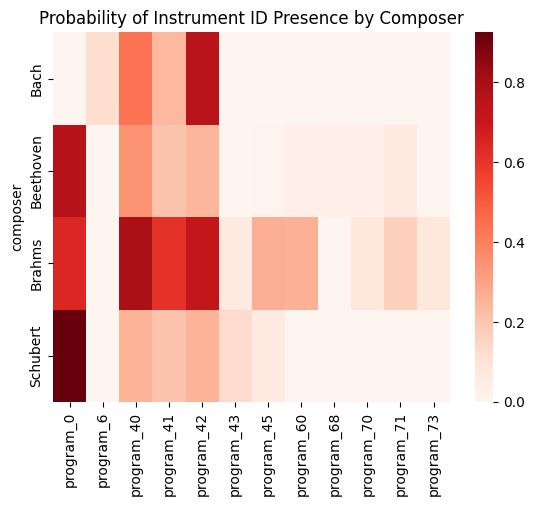

In [10]:
df_plogram_plot = df.groupby('composer')['program_0','program_6','program_40','program_41','program_42','program_43','program_45','program_60','program_68','program_70','program_71','program_73'].mean()
sns.heatmap(df_plogram_plot, cmap='Reds')
plt.title('Probability of Instrument ID Presence by Composer')
plt.show()

In [11]:
num_features = []

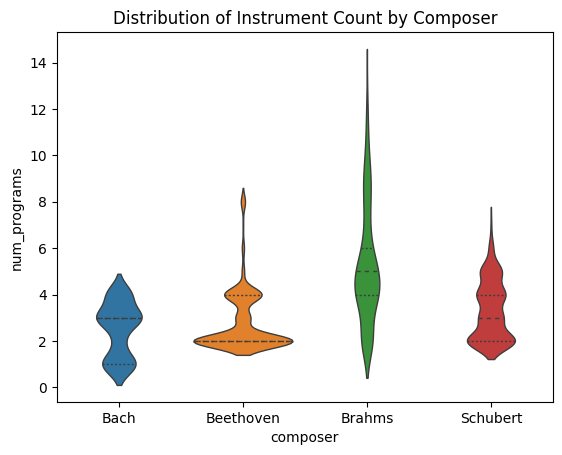

In [12]:
sns.violinplot(data=df, x="composer", y="num_programs", inner="quart", linewidth=1)
plt.title('Distribution of Instrument Count by Composer')
plt.show()
num_features.append('num_programs')

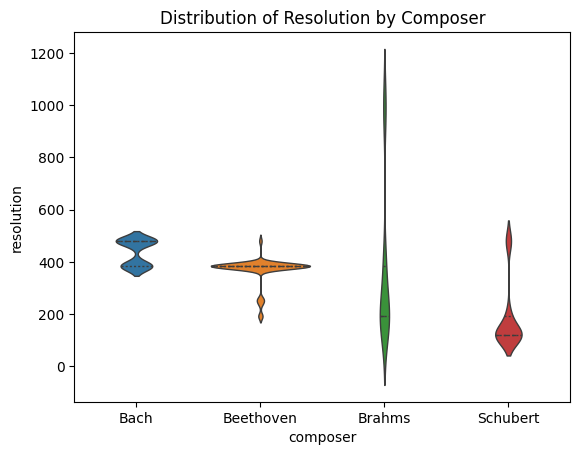

In [13]:
sns.violinplot(data=df, x="composer", y="resolution", inner="quart", linewidth=1)
plt.title('Distribution of Resolution by Composer')
plt.show()
num_features.append('resolution')

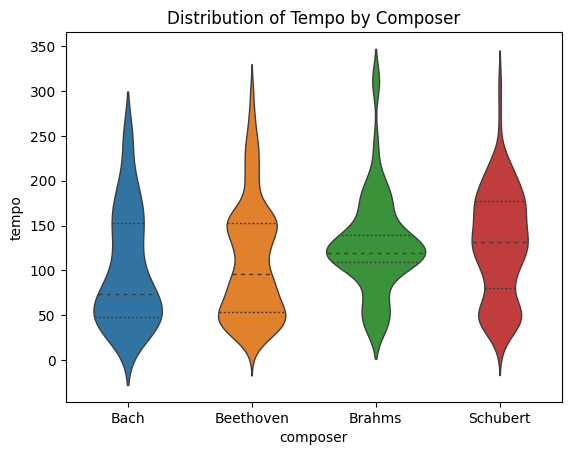

In [14]:
sns.violinplot(data=df, x="composer", y="tempo", inner="quart", linewidth=1)
plt.title('Distribution of Tempo by Composer')
plt.show()
num_features.append('tempo')

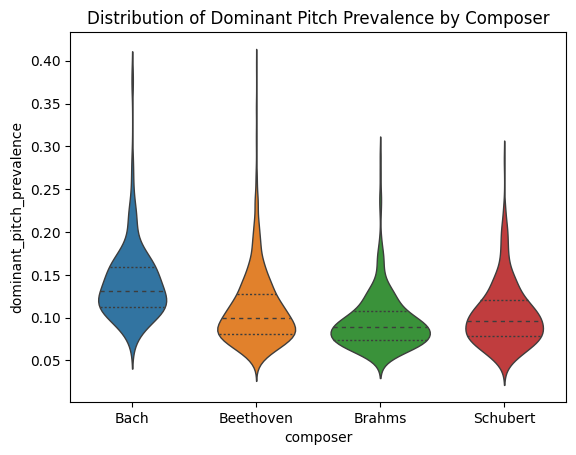

In [15]:
sns.violinplot(data=df, x="composer", y="dominant_pitch_prevalence", inner="quart", linewidth=1)
plt.title('Distribution of Dominant Pitch Prevalence by Composer')
plt.show()

num_features.append('dominant_pitch_prevalence')

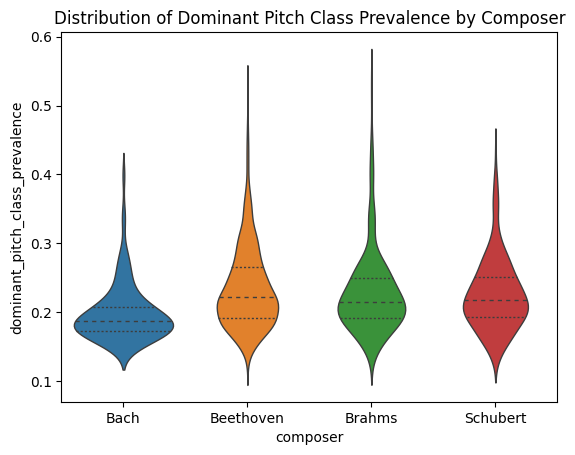

In [16]:
sns.violinplot(data=df, x="composer", y="dominant_pitch_class_prevalence", inner="quart", linewidth=1)
plt.title('Distribution of Dominant Pitch Class Prevalence by Composer')
plt.show()
num_features.append('dominant_pitch_class_prevalence')

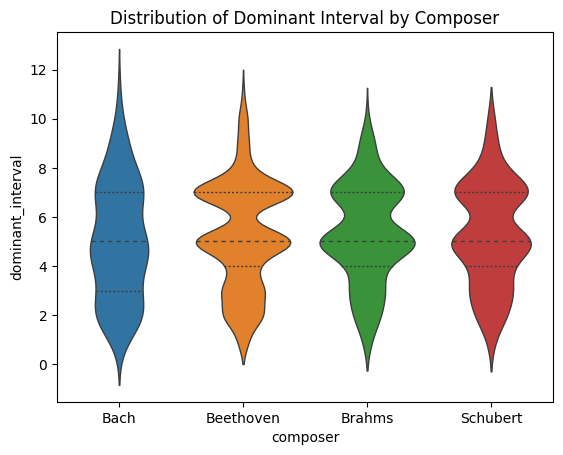

In [17]:
sns.violinplot(data=df, x="composer", y="dominant_interval", inner="quart", linewidth=1)
plt.title('Distribution of Dominant Interval by Composer')
plt.show()
num_features.append('dominant_interval')

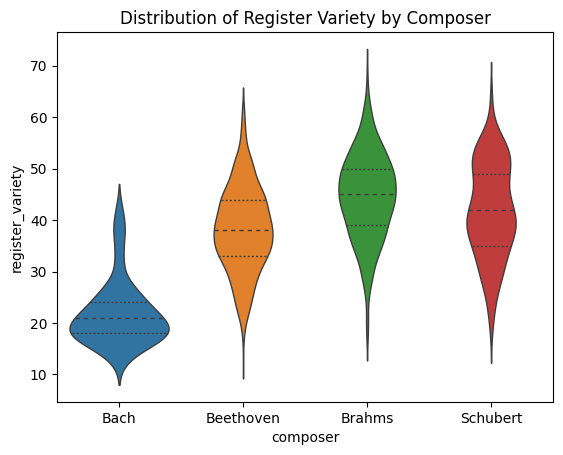

In [18]:
sns.violinplot(data=df, x="composer", y="register_variety", inner="quart", linewidth=1)
plt.title('Distribution of Register Variety by Composer')
plt.show()
num_features.append('register_variety')

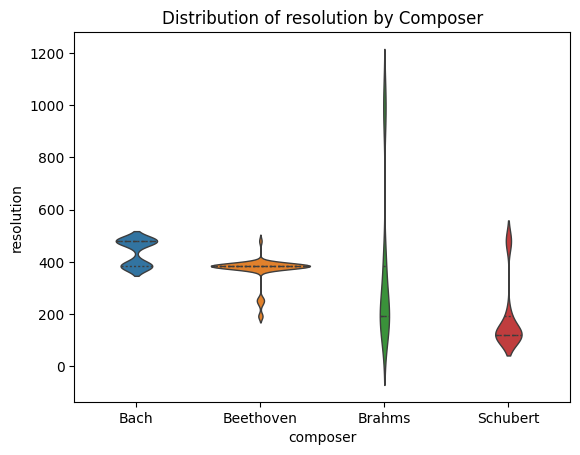

In [19]:
sns.violinplot(data=df, x="composer", y="resolution", inner="quart", linewidth=1)
plt.title('Distribution of resolution by Composer')
plt.show()
# num_features.append('resolution')

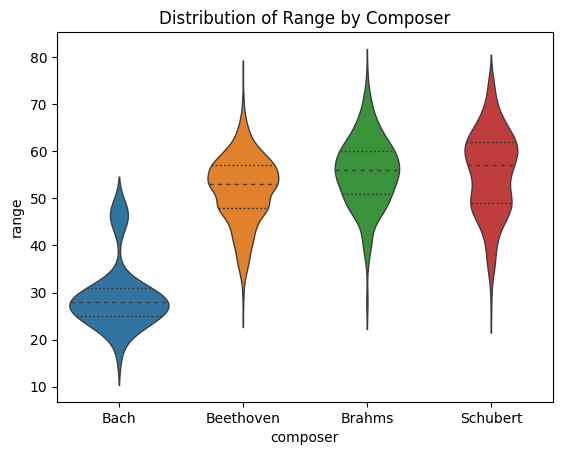

In [20]:
sns.violinplot(data=df, x="composer", y="range", inner="quart", linewidth=1)
plt.title('Distribution of Range by Composer')
plt.show()
num_features.append('range')

- Many numeric features show little variance across all composers, except for Bach

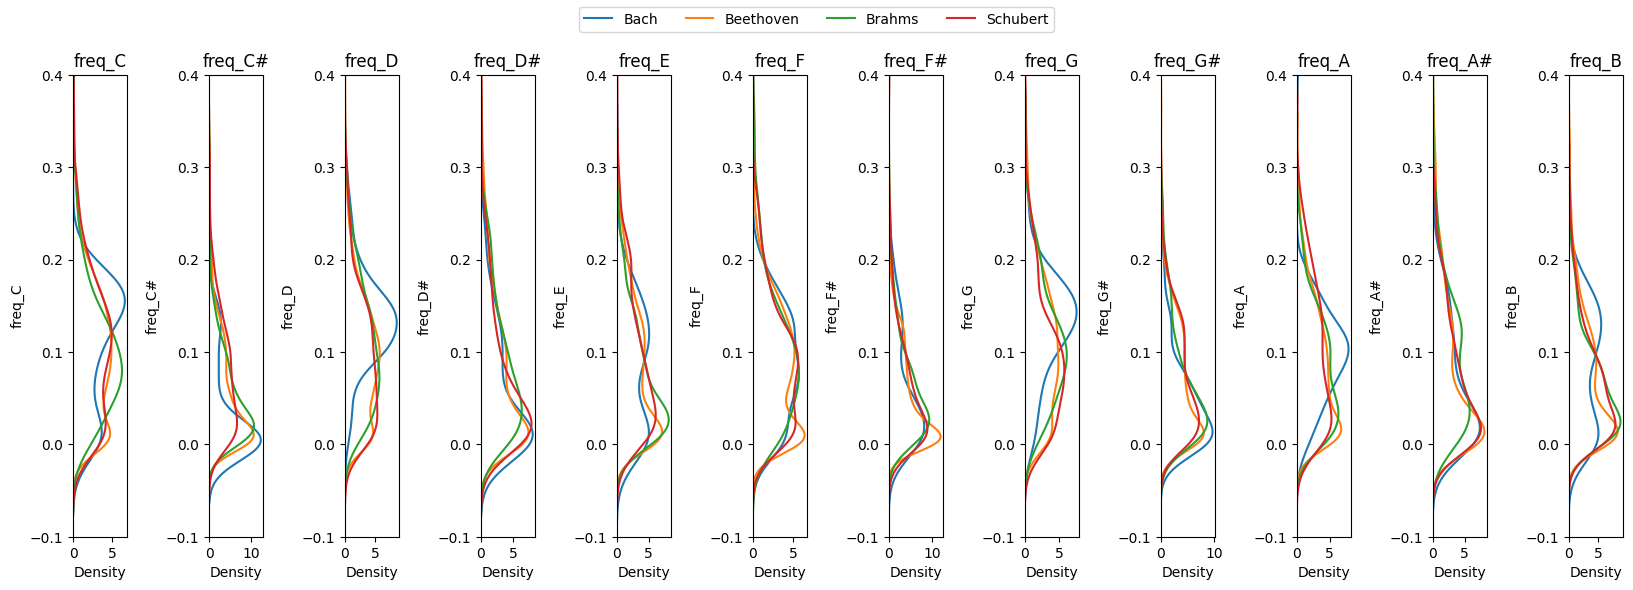

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# create a grid of axes
fig, axes = plt.subplots(nrows=1, ncols=len(pitch_classes_colnames), figsize=(20, 6), sharey=False)

# create empty lists for the legend handles and labels
handles = []
labels = []

for i1, comp in enumerate(composers):
    # loop through the columns and create separate boxplots
    for i, column in enumerate(pitch_classes_colnames):
        sns.kdeplot(data=df.query(f"composer == '{comp}'"), y=column, ax=axes[i])
        axes[i].set_title(column)

    # add the composer to the legend
    handles.append(plt.Line2D([], [], color=sns.color_palette()[i1], label=comp))
    labels.append(comp)

# add the legend to the figure
fig.legend(handles=handles, labels=labels, loc='upper center', ncol=len(labels))

for ax in axes:
    ax.set_ylim(-.1, .4)

# set the y-axis label
# fig.text(0, 0.5, 'Value', va='center', rotation='vertical')

fig.subplots_adjust(wspace=1.5) 
plt.show()

# 'Distribution of Individual Note Frequencies by Composer'

## Predictive Power Scores

In [22]:
ppscore_list = [pps.score(df, colName, 'composer') for colName in num_features+pitch_classes_colnames]
df_pp_score = pd.DataFrame(ppscore_list).sort_values('ppscore', ascending=False)
# df_pp_score

<AxesSubplot:ylabel='x'>

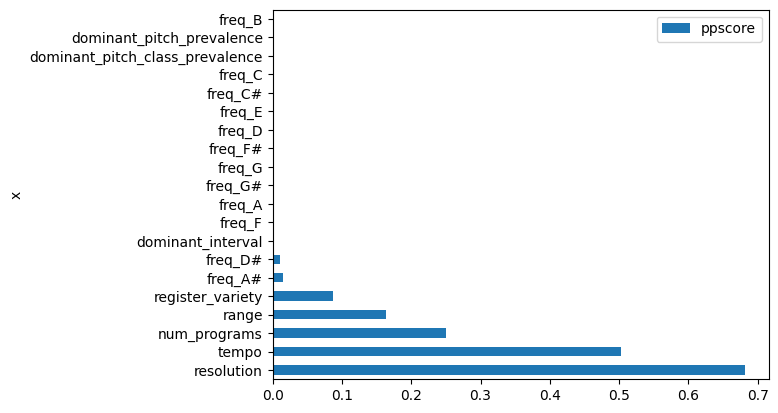

In [23]:
df_pp_score.plot.barh(x='x',y='ppscore')

In [24]:
top_num_features = list(df_pp_score.iloc[0:6]['x'])
top_num_features

['resolution', 'tempo', 'num_programs', 'range', 'register_variety', 'freq_A#']

# 3) Train/ Test Split

## Class Imbalance / Stratified Sampling

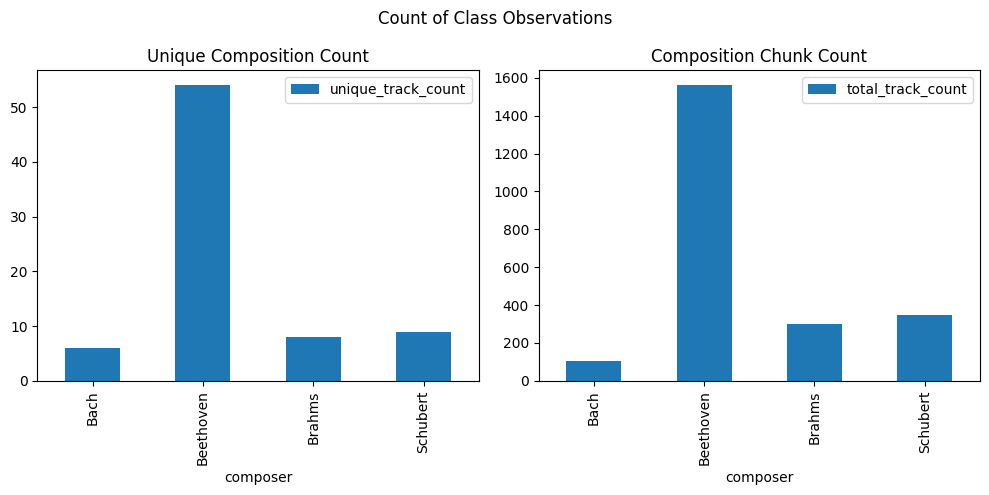

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# group by composer and count unique track names
unique_tracks = df.groupby('composer')['track_name'].nunique().reset_index()
unique_tracks = unique_tracks.rename(columns={'track_name': 'unique_track_count'})

# group by composer and count total track names
total_tracks = df.groupby('composer')['track_name'].count().reset_index()
total_tracks = total_tracks.rename(columns={'track_name': 'total_track_count'})

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot the unique track count subplot
unique_tracks.plot(x='composer', y='unique_track_count', kind='bar', ax=ax1)
ax1.set_title('Unique Composition Count')

# plot the total track count subplot
total_tracks.plot(x='composer', y='total_track_count', kind='bar', ax=ax2)
ax2.set_title('Composition Chunk Count')

# set the title and adjust the layout
fig.suptitle('Count of Class Observations')
fig.tight_layout()

# show the figure
plt.show()


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def stratified_sample(df, strata_col, n_rows):
    """
    Creates a stratified sample of a pandas dataframe with equal proportions for each stratum.
    """
    # Get the unique values in the strata column
    strata_vals = df[strata_col].unique()
    
    # Calculate the sample size for each stratum
    sample_size = int(np.ceil(n_rows / len(strata_vals)))
    
    # Sample an equal number of rows from each stratum
    samples = []
    for val in strata_vals:
        stratum = df[df[strata_col] == val]
        sample = stratum.sample(sample_size, replace=True)
        samples.append(sample)
    
    # Concatenate the samples and return the result
    result = pd.concat(samples)
    return result.sample(n_rows, replace=True)


In [27]:
df_train = df.query("split == 'train'")
df_train_stratified = stratified_sample(df_train, 'target', 5000)
X = df_train_stratified.drop(columns='target')
y = df_train_stratified['target']

# X = df.query("split == 'train'").drop(columns='target')
# y = df.query("split == 'train'")['target']

df_test = df.query("split == 'test'").reset_index()
X_test = df_test.drop(columns='target')
y_test = df_test['target']


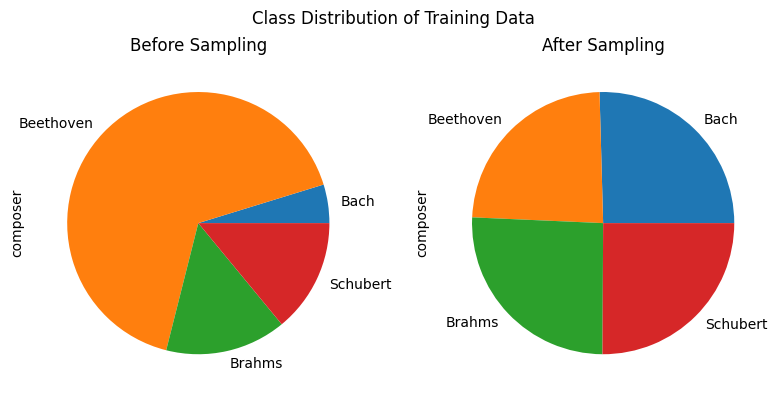

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# create the first pie chart for df_train
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

df_train.composer.value_counts().sort_index().plot.pie(ax=ax1)
ax1.set_title('Before Sampling')

# create the second pie chart for X
X.composer.value_counts().sort_index().plot.pie(ax=ax2)
ax2.set_title('After Sampling')

# set the title and adjust the layout
fig.suptitle('Class Distribution of Training Data')
fig.tight_layout()

# show the figure
plt.show()


# Model Selection, CV, & Tuning

## Final Feature Selection

In [29]:
# Generated lists of feature names
pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
pitch_classes_colnames = [f'freq_{i}' for i in pitch_classes]



# Define passthrough features (already onehot encoded)
one_hot_list2 = [0, 6, 40, 41, 42, 43, 45, 60, 68, 70, 71, 73]
one_hot_list2_colnames = [f'program_{i}' for i in one_hot_list2]
passthrough_cols = one_hot_list2_colnames

# Define categorical columns to be one-hot encoded
# categorical_cols = []

# Define numeric the columns to be scaled
numeric_cols = ['tempo','range','num_programs','register_variety','dominant_interval', 'resolution'] + pitch_classes_colnames 
# numeric_cols = top_num_features
# numeric_cols = ['tempo','range'] + pitch_classes_colnames 



In [30]:
# from category_encoders import EntityEmbeddingEncoder
# encoder = EntityEmbeddingEncoder(cols=one_hot_list2_colnames, embedding_dim=5)

In [31]:
from typing import Dict, Tuple, Any
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV

def run_pipeline(X:Any, y:Any, groups:Any, models:Dict, cv:Any, preprocessor:Any) -> Dict:
    """
    Runs a pipeline with multiple classifiers and parameter grids and returns the best accuracy and parameters for each classifier.

    Args:
        X: input features
        y: target variable
        groups: group labels for group-based cross-validation
        models: a dictionary of models and their parameter grids to train and tune
        cv: cross-validation strategy

    Returns:
        A dictionary with the best accuracy and parameters for each model.
    """
    
    results = {}
    for model_name, (model, param_grid) in models.items():
        group_col_encoder = LabelEncoder()
        X['group_label'] = group_col_encoder.fit_transform(y=groups)

        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring='accuracy')
        grid_search.fit(X, y, groups=X['group_label'])

        best_params = grid_search.best_params_
        best_accuracy = grid_search.best_score_
        best_model = grid_search.best_estimator_

        results[model_name] = (best_accuracy, best_model, best_params)
    return results


In [32]:
from sklearn.model_selection import GroupShuffleSplit

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sklearn.model_selection import GroupShuffleSplit
# ensure cross validation process splits by composition name, for robustness
cv = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Create the preprocessing steps - speficy features and respective transformations
preprocessor = ColumnTransformer(
    transformers=[
        # ('onehot', OneHotEncoder(), categorical_cols),
        ('passthrough', 'passthrough', passthrough_cols),
        ('scaler', StandardScaler(), numeric_cols)])

models = {
    'RandomForest': (RandomForestClassifier(), {'classifier__n_estimators': [100, 200, 500], 'classifier__max_depth': [None, 5, 10, 15, 20]}),
    # 'SVM': (SVC(), {'classifier__C': [0.1, 1, 10], 'classifier__gamma': [0.1, 1, 10], 'classifier__kernel': ['rbf', 'linear']}),
    # 'KNN': (KNeighborsClassifier(), {'classifier__n_neighbors': [3, 5, 7], 'classifier__weights': ['uniform', 'distance'], 'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}),
    # 'GradientBoosting': (GradientBoostingClassifier(), {'classifier__n_estimators': [100, 200, 500], 'classifier__max_depth': [3, 5, 7, 9]}),
    # 'AdaBoost': (AdaBoostClassifier(), {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 1]}),
    # 'XGBoost': (XGBClassifier(), {'classifier__n_estimators': [100, 200, 500], 'classifier__max_depth': [3, 5, 7], 'classifier__learning_rate': [0.01, 0.1, 1]}),
    # 'LightGBM': (LGBMClassifier(), {'classifier__n_estimators': [100, 200, 500], 'classifier__max_depth': [3, 5, 7], 'classifier__learning_rate': [0.01, 0.1, 1]}),
}

results = run_pipeline(X, y, groups=X['track_name'], models=models, cv=cv, preprocessor=preprocessor)

best_model_name = max(results, key=lambda k: results[k][0])
best_model_object = results[best_model_name][1]
best_model_params = results[best_model_name][2]


for i in results:
    print(i,' Training Data CV Accuracy: ',results[i][0])

print("Best model:", best_model_name)
print("Best model parameters:", best_model_params)
print("Best model object:", best_model_object)

RandomForest  Training Data CV Accuracy:  0.6792325823887236
Best model: RandomForest
Best model parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best model object: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['program_0', 'program_6',
                                                   'program_40', 'program_41',
                                                   'program_42', 'program_43',
                                                   'program_45', 'program_60',
                                                   'program_68', 'program_70',
                                                   'program_71',
                                                   'program_73']),
                                                 ('scaler', StandardScaler(),
                                                  ['tempo', 'range',
                         

# Model Validation

In [33]:
def inference(df, model):

    y_pred = model.predict(X_test)
    y_pred_prob_max = model.predict_proba(X_test).max(axis=1)
    
    return pd.Series(y_pred), pd.Series( y_pred_prob_max)

In [34]:
from sklearn.metrics import accuracy_score

best_pipe = best_model_object

# Fit the pipeline on the full training set
best_pipe.fit(X, y)

df_test['pred'], df_test['pred_prob_max'] = inference(df_test, best_pipe)

print(f"test accuracy: {accuracy_score(df_test['target'], df_test['pred'])}" )


test accuracy: 0.8661417322834646


<AxesSubplot:title={'center':'Top 15 Features'}, ylabel='feature'>

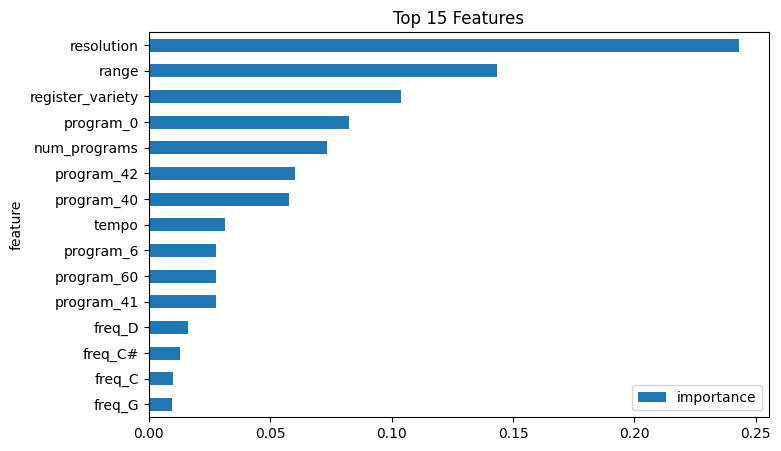

In [35]:
feature_list = np.array(passthrough_cols+numeric_cols)

df_featureImportance = pd.DataFrame()
df_featureImportance['feature'] = feature_list
df_featureImportance['importance'] = best_pipe.named_steps['classifier'].feature_importances_

df_featureImportance.groupby('feature').sum('importance').sort_values(by='importance')[15:].plot(kind='barh', figsize=(8,5), title='Top 15 Features')

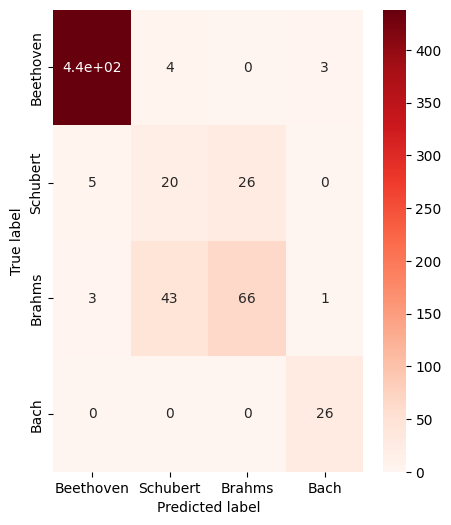

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_pred=df_test['pred'], y_true=df_test['target'])

tick_labels = ['Beethoven', 'Schubert', 'Brahms', 'Bach']
fig, ax = plt.subplots(figsize=(5, 6))
sns.heatmap(cm, annot=True, cmap='Reds', xticklabels=tick_labels, yticklabels=tick_labels, ax=ax)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()


In [42]:
from sklearn.metrics import classification_report
report = classification_report( df_test['target'], df_test['pred'], output_dict=True)
import pandas as pd

# Extract the class names and their corresponding metrics
class_names = list(report.keys())[:-3]
metrics = ['precision', 'recall', 'f1-score']

table = pd.DataFrame(columns=['Class', 'Accuracy'] + metrics)

for cls in class_names:
    # Extract the metrics for the current class
    cls_metrics = [report[cls][m] for m in metrics]
    
    # Calculate the accuracy for the current class
    cls_accuracy = report[cls]['support'] * report[cls]['recall'] / sum([report[c]['support'] * report[c]['recall'] for c in class_names])
    
    # Add the class name, accuracy, and metrics to the table
    table = table.append({'Class': cls, 'Accuracy': cls_accuracy, **{m: cls_metrics[i] for i, m in enumerate(metrics)}}, ignore_index=True)

    table['Class Name'] = table['Class'].apply(lambda x: 'Beethoven' if x=='1' else 'Schubert' if x=='2' else 'Brahms' if x=='3' else 'Bach' if x=='4' else 5)

table['count'] = df_test['target'].value_counts().values

# Print the table
print(table)

  Class  Accuracy  precision    recall  f1-score Class Name  count
0     1  0.796364   0.982063  0.984270  0.983165  Beethoven    445
1     2  0.036364   0.298507  0.392157  0.338983   Schubert    113
2     3  0.120000   0.717391  0.584071  0.643902     Brahms     51
3     4  0.047273   0.866667  1.000000  0.928571       Bach     26


In [57]:
['Beethoven', 'Schubert', 'Brahms', 'Bach'][-1:]

['Bach']

c:\Users\cguid\anaconda3\envs\CG_DS_Env_1\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


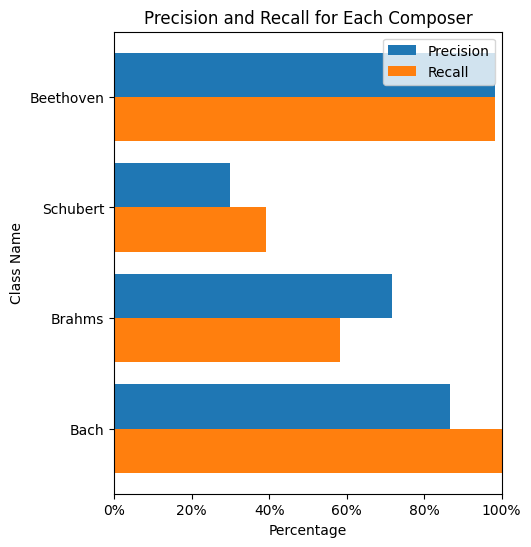

In [60]:
import matplotlib.pyplot as plt

# Define the class names and corresponding precision and recall values
class_names = ['Beethoven', 'Schubert', 'Brahms', 'Bach'][::-1]
precision = [0.982, 0.299, 0.717, 0.867][::-1]
recall = [0.984, 0.392, 0.584, 1.0][::-1]

# Plot the precision and recall values for each class as grouped bars
fig, ax = plt.subplots(figsize=(5, 6))
ax.barh(class_names, precision, height=0.4, align='edge', label='Precision')
ax.barh(class_names, recall, height=-0.4, align='edge', label='Recall')
ax.set_xlim([0, 1])
ax.set_xlabel('Percentage')
ax.set_ylabel('Class Name')
ax.set_title('Precision and Recall for Each Composer')
ax.legend()

# Convert the x-axis ticks to percentages
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])



plt.show()


In [38]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(df_test['target'], df_test['pred'])

# Calculate specificity for each class
num_classes = conf_matrix.shape[0]
specificities = []
for i in range(num_classes):
    tn = sum(conf_matrix[j][k] for j in range(num_classes) if j != i for k in range(num_classes) if k != i)
    fp = sum(conf_matrix[j][i] for j in range(num_classes) if j != i)
    specificity = tn / (tn + fp)
    specificities.append(specificity)

print('Specificity for each class:', specificities)

Specificity for each class: [0.9578947368421052, 0.9195205479452054, 0.9501915708812261, 0.993431855500821]


In [37]:
df_test['target'].value_counts()/df_test['target'].shape[0]

1    0.700787
3    0.177953
2    0.080315
4    0.040945
Name: target, dtype: float64

# Perform Inference

In [37]:
# Chunk-level predictions

df_final_test['pred'], df_final_test['pred_prob_max'] = inference(df_final_test, best_pipe)

df_final_test['pred_given_composer_present'] = df_final_test['prob'].apply(lambda p: 0 if p > .5 else 1)

df_final_test['pred_composer_not_present'] = df_final_test['pred_prob_max'].apply(lambda p: 1 if p < .65 else 0)


In [38]:
# Song-level predictions

# Unclear requirement(s):
    # Each composition must be given one prediction AND the model must accept 30 second chunks.
    # There are multiple chunks per composition, so for simplicity we will predict on the first chunk of the composition. 

# Test/Inference data Filenames:
    # It is unclear whether the 'track_path_original' is of any value. It appears to be a predicted probability from another model.
    # It is still shown, given the assumption that it is an accurate / meaningful baseline.

df_final_test_songlevel = (
    df_final_test.query("iter == '1'").groupby('track_path_original').agg(
        
        pred_composer_not_present_given = ('pred_given', 'first'),

        pred_prob_max = ('pred_prob_max', 'first'),
        pred = ('pred_composer_not_present', 'first'),
    )
)
df_final_test_songlevel

,pred_composer_not_present_given,pred_prob_max,pred
track_path_original,,,
0.002716920481628_adj.mid,0,0.792591,0
0.033313986422223163_adj.mid,0,0.952921,0
0.047574444458241216_adj.mid,0,0.663331,0
0.06402123326764841_adj.mid,0,0.676515,0
0.07186746659481313_adj.mid,0,0.721305,0
0.09167358800381353_adj.mid,0,0.699655,0
0.10222964826466285_adj.mid,0,0.505716,1
0.10250888365879718_adj.mid,0,0.671605,0
0.10630249969742178_adj.mid,0,0.688750,0


In [39]:
df_final_test_songlevel.to_csv('../data/out/final_test_preds.csv')
